In [2]:
import os
import re
import torch
from torch import nn
import matplotlib.pyplot as plt 
from d2l import torch as d2l
#from d2l1 import torch as d2l1

# 1.TextCNN

# Input

### Read dataset: from pos/neg text.txt

In [3]:
data_dir=os.getcwd()

In [4]:
def read_kick(data_dir, is_train):
    """读取kick文本序列和标签"""
    data, labels = [],[]
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'speech_train' if is_train else 'speech_test',label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.readlines()
                for i in range(10):
                    try:
                        review[i] = review[i].decode('iso-8859-1')
                        pattern = re.compile(r'\\?n|b\'?|\'?$')
                        review[i]=re.sub(pattern,'',review[i])
                        review[i]=review[i].replace('\t ', '').replace(',', '').replace('.', '').replace("'", "").replace('[', '').replace(']', '').replace('/','').strip()
                        data.append(review[i])
                        labels.append(1 if label == 'pos' else 0)
                    except IndexError:
                        pass

    return data,labels



In [5]:
len(read_kick(data_dir, True)[0])

144

### Preprocess: tokenize(word),vocab(filter),steps(padding&truncate)

In [12]:
train_data=read_kick(data_dir, True)
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=1, reserved_tokens=['<pad>']) #vocab长度56246
num_steps=512
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])

205.45833333333334


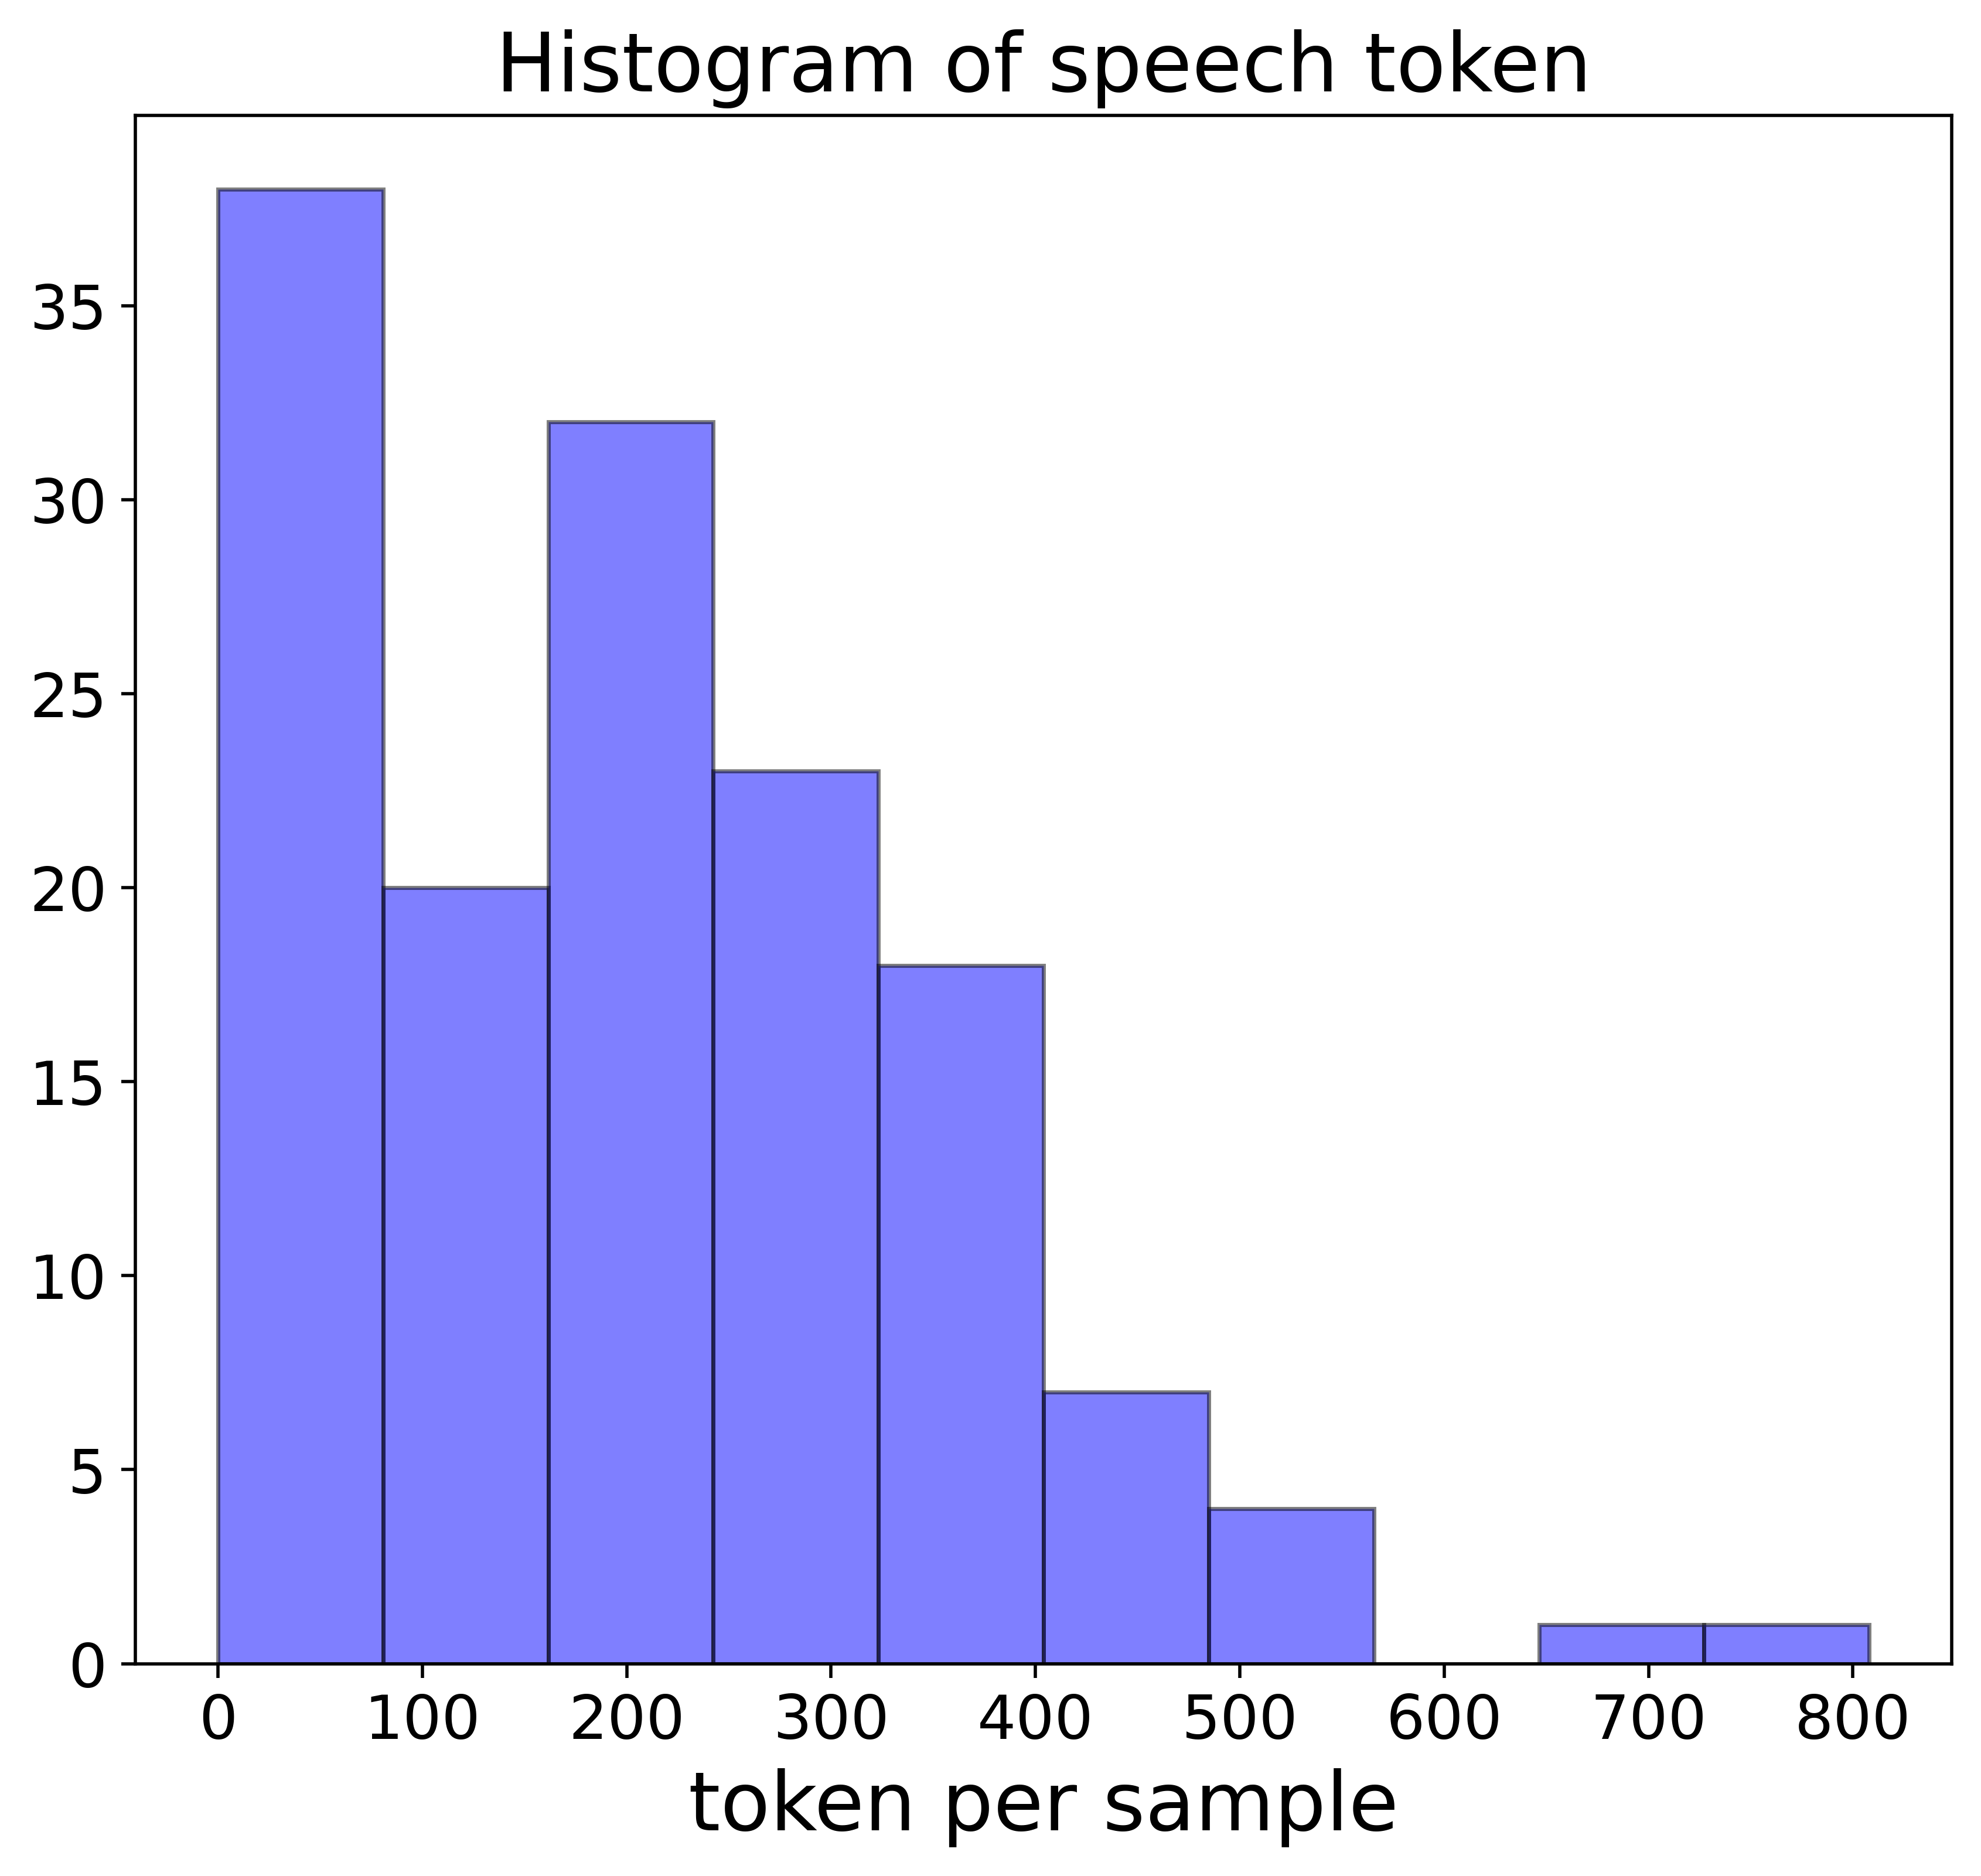

In [13]:
b=[]
for i in range(len(train_tokens)):
    a=len(train_tokens[i])
    b.append(a)
sum(b)
meantoken=sum(b)/len(train_tokens)
print(meantoken)
fig=plt.figure(figsize=(8, 7), dpi=500)
plt.hist(b, bins=10, alpha=0.5, color='blue',edgecolor='black')
plt.title('Histogram of speech token',fontsize=20)
plt.xlabel('token per sample',fontsize=20)
#plt.ylabel('counts',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('Histogramofspeechtoken.png', dpi=500)
plt.show()

In [7]:
len(vocab)

6002

In [8]:
vocab['good']

127

In [9]:
train_data[0]

['"Wilderess is ot a luxury Its i our veis For whe everyday Advetures lead to uexpected experieces hyper shell as the power ad techology that takes you there The M1 ioic motor ca offset upto 30 kilos of weight"  Gai extra horsepower i hypermoile eve at your est pace  Move fast reak records make a history of your ow " Dot drive it live i it hyper shell exteds your ody with 14 High Precisio sesors that capture your itetio ad step i with zero delay the full alloy frame ad weatherproof desig make hyper shell icredily light ad sturdy"  Hyper shell ca e easily folded ad stuffed ito almost ay ackpack The high-desity atteries will take you there ad ack agai Exted 16 miles rage for sigle day use ad rest assured Eve i multi day trips easily move through the day with a motio egie that adapts to 12 miles per hour pace ad 60Â° clim with te additioal joits  Like short step further with Hyper shell  Okay',
 'Itroducig the oly wearale techology uilt for weightliftig " Whether youre workig out at the g

In [9]:
train_tokens

['"Wilderess',
 'is',
 'ot',
 'a',
 'luxury',
 'Its',
 'i',
 'our',
 'veis',
 'For',
 'whe',
 'everyday',
 'Advetures',
 'lead',
 'to',
 'uexpected',
 'experieces',
 'hyper',
 'shell',
 'as',
 'the',
 'power',
 'ad',
 'techology',
 'that',
 'takes',
 'you',
 'there',
 'The',
 'M1',
 'ioic',
 'motor',
 'ca',
 'offset',
 'upto',
 '30',
 'kilos',
 'of',
 'weight"',
 'Gai',
 'extra',
 'horsepower',
 'i',
 'hypermoile',
 'eve',
 'at',
 'your',
 'est',
 'pace',
 'Move',
 'fast',
 'reak',
 'records',
 'make',
 'a',
 'history',
 'of',
 'your',
 'ow',
 '"',
 'Dot',
 'drive',
 'it',
 'live',
 'i',
 'it',
 'hyper',
 'shell',
 'exteds',
 'your',
 'ody',
 'with',
 '14',
 'High',
 'Precisio',
 'sesors',
 'that',
 'capture',
 'your',
 'itetio',
 'ad',
 'step',
 'i',
 'with',
 'zero',
 'delay',
 'the',
 'full',
 'alloy',
 'frame',
 'ad',
 'weatherproof',
 'desig',
 'make',
 'hyper',
 'shell',
 'icredily',
 'light',
 'ad',
 'sturdy"',
 'Hyper',
 'shell',
 'ca',
 'e',
 'easily',
 'folded',
 'ad',
 'stuf

### mini-batch input:train_iter,test_iter,vocab

In [121]:
def load_data_kick(batch_size, num_steps):
    """返回数据迭代器和kickstarter数据集的词表"""
    
    train_data = read_kick(data_dir,True)
    test_data = read_kick(data_dir,False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=1)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab


# Model

In [122]:
batch_size,num_steps =8,512
train_iter, test_iter, vocab = load_data_kick(batch_size,num_steps)

### TextRNN(vocabsize,embedsize,numhidden,numlayer)()

In [123]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 这个嵌入层不需要训练
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # 最大时间汇聚层没有参数，因此可以共享此实例
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # 创建多个一维卷积层
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # 沿着向量维度将两个嵌入层连结起来，
        # 每个嵌入层的输出形状都是（批量大小，词元数量，词元向量维度）连结起来
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # 根据一维卷积层的输入格式，重新排列张量，以便通道作为第2维
        embeddings = embeddings.permute(0, 2, 1)
        # 每个一维卷积层在最大时间汇聚层合并后，获得的张量形状是（批量大小，通道数，1）
        # 删除最后一个维度并沿通道维度连结
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

### params initiate

In [124]:
embed_size, kernel_sizes, nums_channels = 100, [3,4,5], [100, 100, 100]
devices=d2l.try_all_gpus()
#devices=d2l1.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

In [125]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

In [126]:
embeds.shape

torch.Size([6001, 100])

In [127]:
embeds[246]

tensor([-0.4315, -0.2204, -0.2268, -0.1022, -0.3186, -0.1181, -0.0934, -0.0698,
        -0.2903, -0.3401,  0.0997, -0.0593, -0.4376,  0.1946,  0.3700,  0.7365,
        -0.5343, -0.3469, -0.2141,  0.6295,  0.5487,  0.2943, -0.3289, -0.6177,
        -0.0396,  0.9164, -0.6405,  0.2873,  0.0959, -0.3877, -0.6296,  0.3344,
        -0.4856, -0.2287,  0.8428, -0.2204, -0.1326, -0.1819,  0.0777,  0.0800,
        -0.0189, -0.2602,  0.2954, -0.8917, -0.3937, -0.3566,  0.0117, -0.3766,
         0.6458, -0.8650,  0.1261,  0.1898, -0.2694,  0.5622,  0.3822, -2.1389,
        -0.0096,  0.1504,  1.2586, -0.3548, -0.3329,  0.0729, -0.0773,  0.0491,
         0.9021, -0.2754, -0.2084,  0.2635, -0.2652, -0.7059, -0.6847,  0.3842,
        -0.2189, -0.8855,  0.3858,  0.2648, -0.7641, -0.0375, -0.0206, -0.7132,
         1.1045,  0.0453, -0.4190, -0.4767, -1.4088, -0.5038,  0.8806,  0.0072,
        -0.4208, -0.6259,  0.5961,  0.3044, -0.4100, -0.2820, -0.5232, -0.4469,
         0.2108, -0.0102,  0.0086,  0.63

# Trainging

loss 0.439, train acc 0.778, test acc 0.545
117.5 examples/sec on [device(type='cpu')]


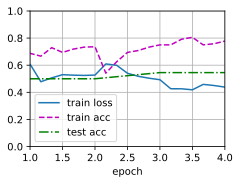

In [129]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)
#12;00-12:13-12:19
#14;09

# 2.BiRNN

In [ ]:
batch_size,num_steps = 16,512
train_iter, test_iter, vocab = load_data_kick(batch_size,num_steps)

In [ ]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

#### params initiate

In [ ]:
embed_size, num_hiddens, num_layers = 100, 100, 2
devices = d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

# Training

In [ ]:
lr, num_epochs = 0.01, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
#d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

# 3. BERT+MLP

In [ ]:
def read_kick(data_dir, is_train):
    """读取kick文本序列和标签"""
    data1,data2, labels = [],[],[]
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'speech_train' if is_train else 'speech_test',label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.readlines()
                for i in range(10):
                    try:
                        review[i] = review[i].decode('iso-8859-1')
                        pattern = re.compile(r'\\?n|b\'?|\'?$')
                        review[i]=re.sub(pattern,'',review[i])
                        review[i]=review[i].replace('\t ', '').replace(',', '').replace('.', '').replace("'", "").replace('[', '').replace(']', '').replace('/','').strip()
                        data1.append(review[i])
                        data2.append(review[i])
                        labels.append(1 if label == 'pos' else 0)
                    except IndexError:
                        pass

    return data1,data2,labels



In [ ]:
#d2l.plt.hist([len(d2l.tokenize(train_data[0][i])) for i in range(len(train_data[0]))], bins=range(0, 1000, 50));

train_data = read_kick(data_dir,is_train=True)
for x0, x1,y in zip(train_data[0][12:16], train_data[1][12:16],train_data[2][12:16]):
    print('p：', x0)
    print('h：', x1)
    print('l：', y)

In [ ]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [ ]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # 定义空词表以加载预定义词表
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir,
        'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[768],
                         ffn_num_input=768, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=12, num_layers=12, dropout=0.1,
                         max_len=max_len, key_size=768, query_size=768,
                         value_size=768, hid_in_features=768,
                         mlm_in_features=768, nsp_in_features=768)
    # 加载预训练BERT参数
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

In [ ]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.base', num_hiddens=768, ffn_num_hiddens=3072, num_heads=12,
    num_layers=12, dropout=0.1, max_len=512, devices=devices)

In [ ]:
class KickBertDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [
            p_tokens for p_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # 使用4个进程
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [ ]:
batch_size, max_len, num_workers = 2, 512, d2l.get_dataloader_workers()

train_set = KickBertDataset(read_kick(data_dir,True), max_len, vocab)
test_set = KickBertDataset(read_kick(data_dir,False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(768, 2)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In [ ]:
net = BERTClassifier(bert)

In [ ]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)